In [24]:
import cv2
import glob
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPRegressor

from src.timeline import Timeline
from src.utils.cube import generate_cube, draw_cube
from src.frame import Frame
from src.utils.reprojection import reprojection_distance

In [2]:
timeline = Timeline()

Buffering: start...
Reading from images sequence in frames folder...
Buffering: done
Keyframes recovering: start...
Keyframes recovering: done
Keyframe bundle adjustment: start...
Generation 0 has Chi-Squared: 8241.189328
Generation 50 has Chi-Squared: 3644.452732
Generation 100 has Chi-Squared: 3557.409837
Generation 150 has Chi-Squared: 3545.636654
Generation 200 has Chi-Squared: 3404.933493
Generation 250 has Chi-Squared: 3329.560960
Generation 300 has Chi-Squared: 3125.307016
Generation 350 has Chi-Squared: 1068.204427
Generation 400 has Chi-Squared: 1061.138651
Generation 450 has Chi-Squared: 1059.075182
Generation 500 has Chi-Squared: 1057.114688
STOP("EvaluationLimits with {'evaluations': 60000, 'generations': 500}")
Generation 0 has Chi-Squared: 37223.271975
Generation 50 has Chi-Squared: 4553.366504
Generation 100 has Chi-Squared: 4453.636970
Generation 150 has Chi-Squared: 4370.700437
Generation 200 has Chi-Squared: 4361.555021
Generation 250 has Chi-Squared: 4357.025401
Gene

In [41]:
keyframe = timeline.keyframes[1]
keyframe2 = timeline.keyframes[2]
adjusted_keyframe = timeline.adjusted_keyframes[1]
frame = Frame(keyframe.image)

## Feature detection and matching

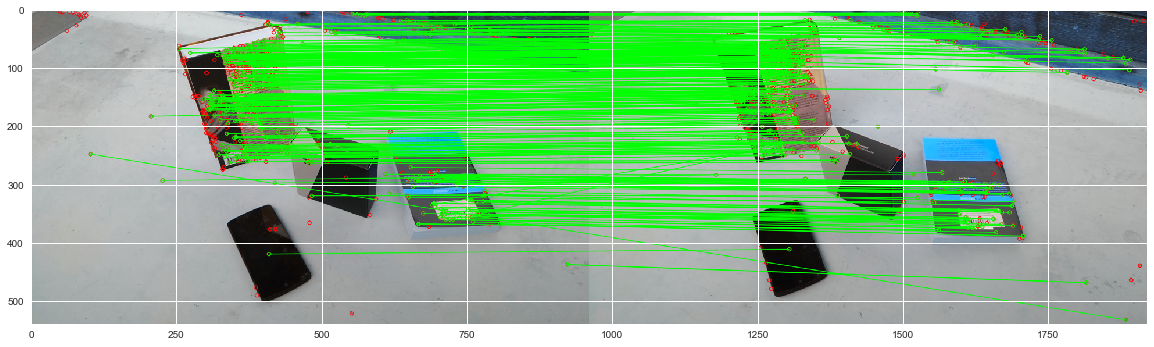

In [43]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(keyframe.des, keyframe2.des, k=2)
matchesMask = [[0,0] for i in range(len(matches))]
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(keyframe.image, keyframe.kp, keyframe2.image, keyframe2.kp, matches,None,**draw_params)
plt.figure(figsize=(20,10))
plt.imshow(img3)
plt.show()

## 3d scene reconstruction 

In [37]:
from pyntcloud import PyntCloud
df_points = pd.DataFrame(keyframe.points_3d.reshape(keyframe.points_3d.shape[0], 3), columns=['x', 'y', 'z'])
colors = (np.random.uniform(size=(keyframe.points_3d.shape[0], 3)) * 255).astype(np.uint8)
df_points[['red', 'blue', 'green']] = pd.DataFrame(colors, index=df_points.index)
cloud = PyntCloud(df_points)
cloud.plot(point_size=0.05, opacity=0.6, lines=[[[0, 0, 0], [0, 0, 1]]], line_color=[0xFFFFFF])

## Bundle adjustment demo

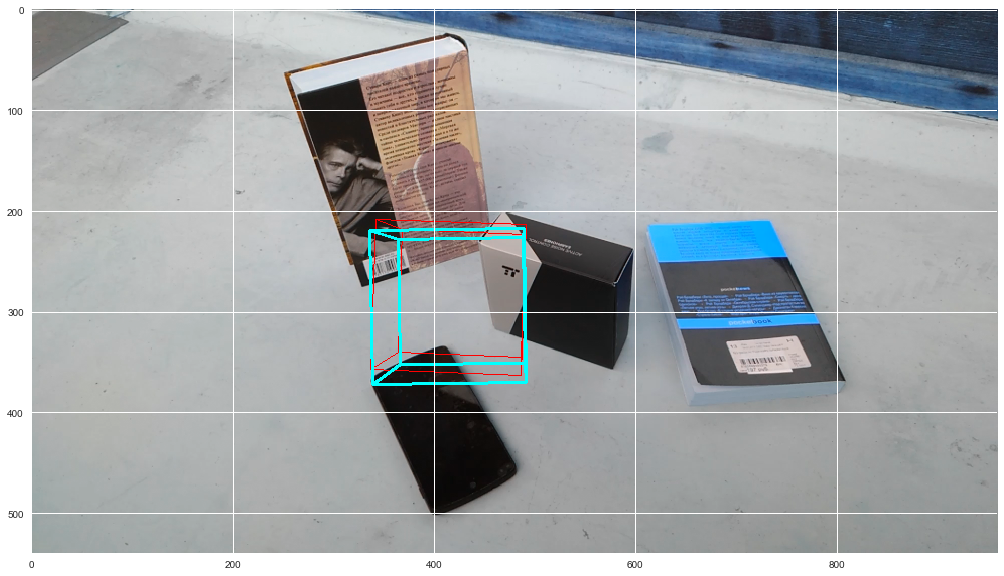

In [35]:
cube = generate_cube(1.0, [0,0,10])
image = draw_cube(frame.image, keyframe.create_camera_and_project(cube), color=(255, 0, 0), wide=1)
image = draw_cube(image, adjusted_keyframe.create_camera_and_project(cube), color=(0, 255, 255), wide=2)
plt.figure(figsize=(20,10))
plt.imshow(image)
plt.show()